In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import dynetx as dn

from general_graph_utils import *

# plot formatting
plt.rc("text", usetex=False)
plt.rc("font", family = "serif")
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

**Goals of simulation**

* Initialize a system of N particles in finite space
* Each particle assigned a speed v and direction of motion r
* Each particle exists in one of two states:
    * "Run" state: particle moves in a straight line forming a polymer link with finite probability => adds an edge
    * "Tumble" state: particle changes direction => adds a node
   

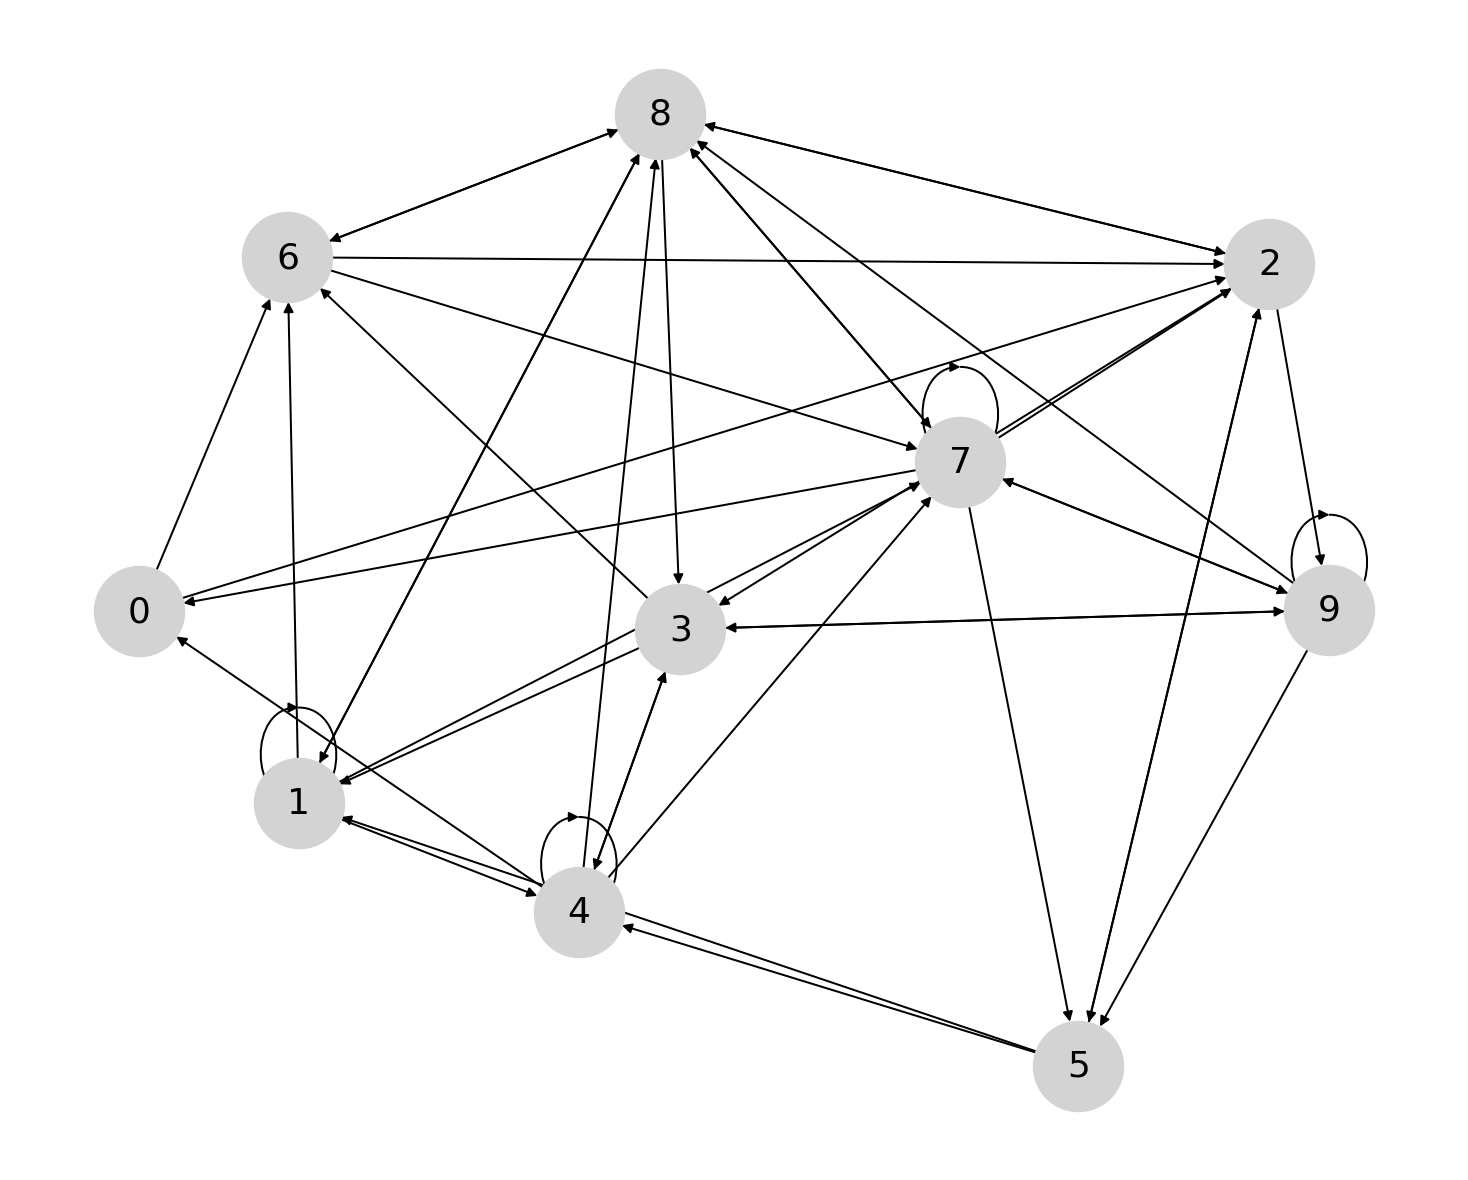

In [22]:
g = dn.DynDiGraph()
time = 0 # initial time

# initial particle locations
p_1 = 1 
p_2 = 2
p_3 = 3
p_4 = 4
p_5 = 5

# dynamically create network
while time < 10:
    
    # set destination of particle
    v_1 = np.random.choice(10, 1)[0]
    v_2 = np.random.choice(10, 1)[0]
    v_3 = np.random.choice(10, 1)[0]
    v_4 = np.random.choice(10, 1)[0]
    v_5 = np.random.choice(10, 1)[0]
    
    # add edges
    g.add_interaction(u=p_1, v=v_1, t=time)
    g.add_interaction(u=p_2, v=v_2, t=time)
    g.add_interaction(u=p_3, v=v_3, t=time)
    g.add_interaction(u=p_4, v=v_4, t=time)
    g.add_interaction(u=p_5, v=v_5, t=time)
    
    # reset particle locations
    p_1 = v_1
    p_2 = v_2
    p_3 = v_3
    p_4 = v_4
    p_5 = v_5
    
    # advance time
    time +=1

nx.draw(g, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

**Problems:**

* No geometry constraint
    * Graph is a topological object in all of these libraries
    * Potential solution: Gurobi
* No velocity/direction implemented
* Run/tumble combined